# 06.01 - CLUSTERING

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

In [5]:
import warnings
warnings.filterwarnings('ignore')
from local.lib import mlutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from IPython.display import HTML, Image

%matplotlib inline

## Referencias generales

- [Cluster Analysis on Wikipedia](https://en.wikipedia.org/wiki/Cluster_analysis)
- [Cluster Analysis, Basic concepts and algorithms](https://www-users.cs.umn.edu/~kumar001/dmbook/ch8.pdf)


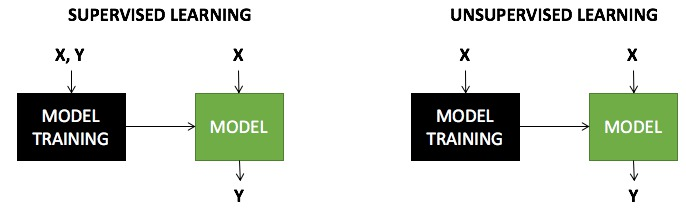

In [6]:
Image(filename='local/imgs/learning.jpg', width=600)

**Qué es clustering?**

- **Objetivo**: agrupar objetos físicos o obstractos en clases de objetos **similares**
- Es una tarea **NO SUPERVISADA** $\rightarrow$ no sabemos a priorí cómo clasificar nuestros objetos
- Es una tarea **NO COMPLETAMENTE DEFINIDA** $\rightarrow$ ¿Cómo cuantificamos el desempeño de un resultado de clustering?


- ¿Qué definición de **similitud** establecemos?

**Ejemplos de aplicaciones de clustering**

- Taxonomías en biología, agrupaciones por similitud biológica, o incluso genética (big data!!)
- Páginas similares para estructurar resultados de búsquedas (p.ej. La búsqueda de "película" podría devolver resultados agrupados por descripciones similares.
- Segmentación de clientes o usuarios por un criterio de similitud definido.


## Intuición

¿Qué grupos harías con los siguientes datos?,  ¿Cómo sería el proceso?

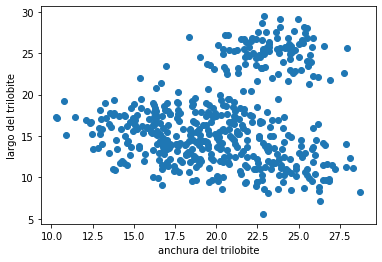

In [55]:
X = pd.read_csv("local/data/cluster1.csv").values+15
plt.scatter(X[:,0], X[:,1])
plt.xlabel("anchura del trilobite")
plt.ylabel("largo del trilobite");

pseudo código

    input: 
        X: datos
        k: número de clusters deseados
        
    algoritmo:
        1. selecciona k centroides aleatoriamente
        2. repite hasta que los k centroides no cambien:
        3.     establece k clusters asignado cada dato al centroide más cercano
        4.     recalcula el centroide de cada cluster como el promedio de los datos

In [7]:
h = '<iframe width="560" height="315" src="https://www.youtube.com/embed/BVFG7fd1H30" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>'
HTML(h)

## Métodos basados en centroides -  KMeans


In [9]:
X = pd.read_csv("local/data/cluster1.csv").values+15
X.shape

(500, 2)

In [11]:
X[:10]

array([[16.06479619, 15.64135085],
       [23.136145  , 13.27029397],
       [21.2907726 , 25.33499533],
       [24.4739302 , 24.28665806],
       [16.29365483, 17.15224079],
       [24.3799962 , 21.6928672 ],
       [22.96399174, 13.7776461 ],
       [14.59797792, 16.23800883],
       [21.68532999, 18.31450552],
       [21.74355998, 23.70715595]])

In [12]:
n_clusters = 2

km = KMeans(n_clusters=n_clusters)
km.fit(X)
y = km.predict(X)
y.shape

(500,)

In [13]:
pd.Series(y).value_counts()

0    392
1    108
dtype: int64

In [14]:
km.cluster_centers_

array([[19.5061742 , 14.31526768],
       [23.01615594, 24.85357474]])

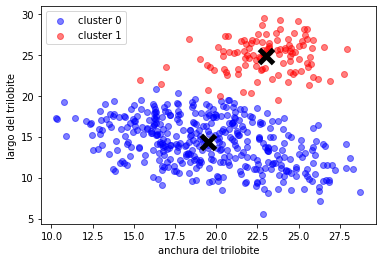

In [15]:
def plot_clusters(X,y):
    n_clusters = len(np.unique(y))
    cmap = plt.cm.bwr if n_clusters==2 else plt.cm.plasma
    cmap((y*255./(n_clusters-1)).astype(int))
    for i in np.unique(y):
        col = cmap((i*255./(n_clusters-1)).astype(int))
        Xr = X[y==i]
        plt.scatter(Xr[:,0], Xr[:,1], color=col, label="cluster %d"%i, alpha=.5)
    plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1],marker="x", lw=5, s=200, color="black")
    plt.legend()    
    plt.xlabel("anchura del trilobite")
    plt.ylabel("largo del trilobite");



plot_clusters(X,y)

observa cómo KMeans agrupa datos en 2D con diferentes números de clusters

100% (8 of 8) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


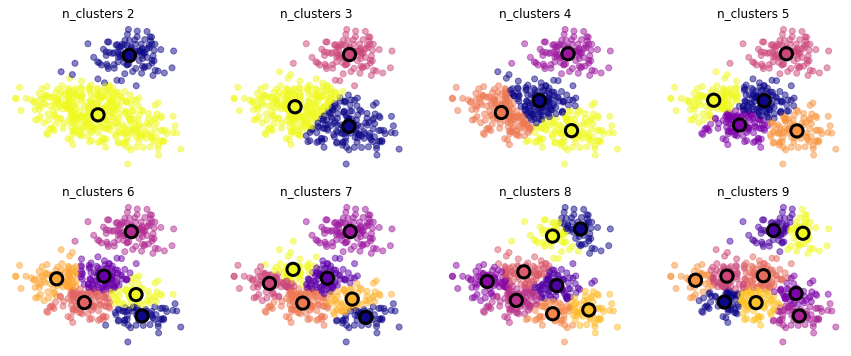

In [18]:
X = pd.read_csv("local/data/cluster1.csv").values
mlutils.experiment_number_of_clusters(X, KMeans(), show_metric=False)

### exerimenta con distintos datasets sintéticos

- cambia `cluster_std` y `centers` en `make_blobs` para generar datasets con distintas distribuciones
- cuál es el númer de clusters _natural_ que usarías? por qué es _natural_?

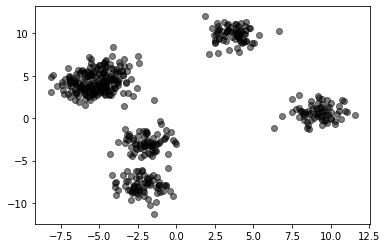

In [19]:
X,_ = make_blobs(500, cluster_std=1, centers=7)
plt.scatter(X[:,0], X[:,1], color="black", alpha=.5)

100% (8 of 8) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


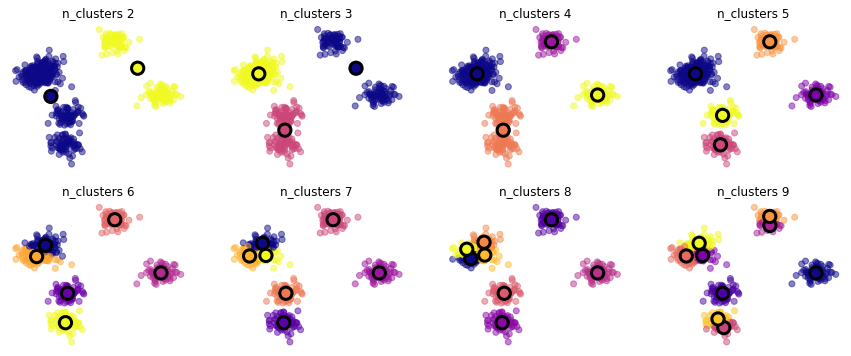

In [20]:
mlutils.experiment_number_of_clusters(X, KMeans(), show_metric=False)

### Cómo seleccionar el número de clusters? Consulta <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">Silhouette Coefficient</a>

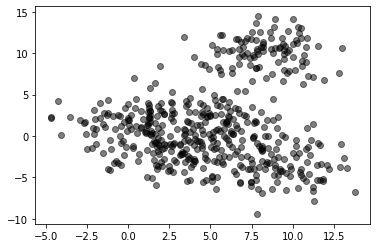

In [22]:
X = pd.read_csv("local/data/cluster1.csv").values
plt.scatter(X[:,0], X[:,1], alpha=.5, color="black")

In [29]:
def silhouette_analysis(X):
    range_n_clusters = [2, 3, 4, 5, 6]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(19, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for %s clustering on sample data "
                      "with n_clusters = %d, score = %.3f" % (clusterer.__class__.__name__, n_clusters,silhouette_avg)),
                     fontsize=14, fontweight='bold')

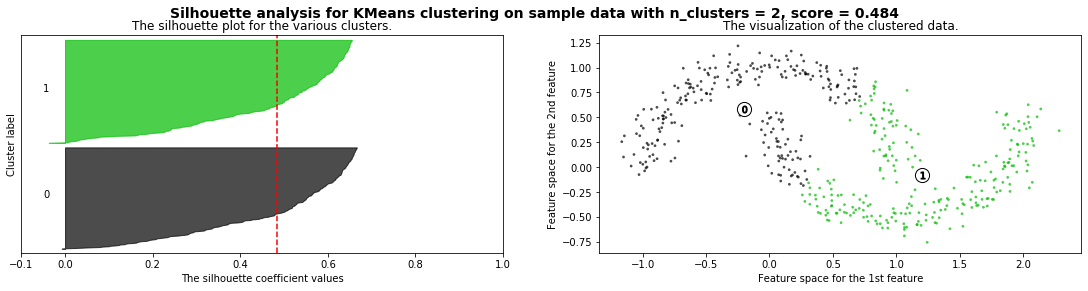

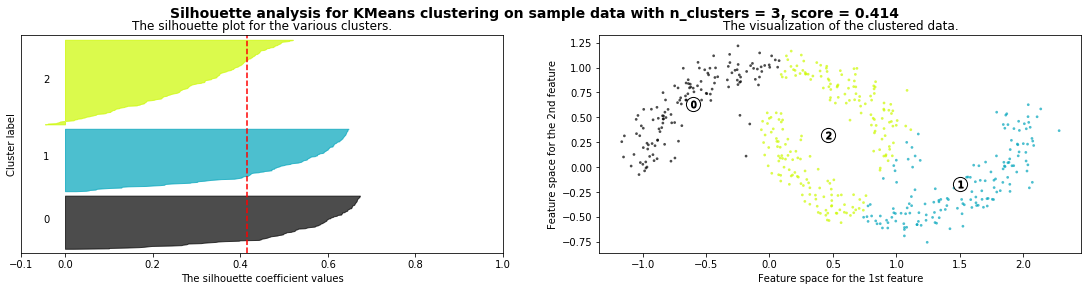

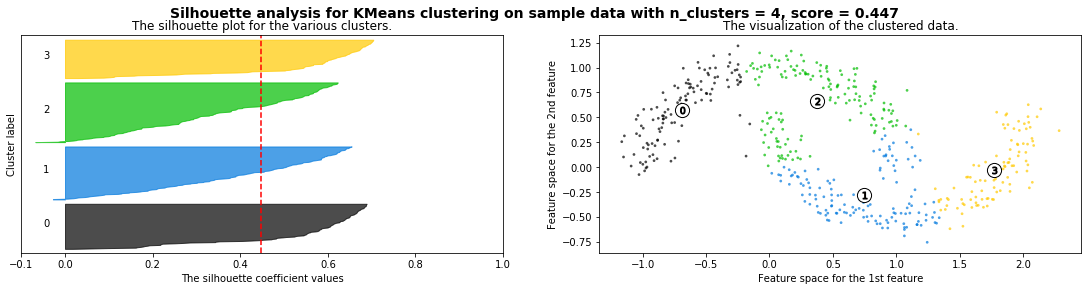

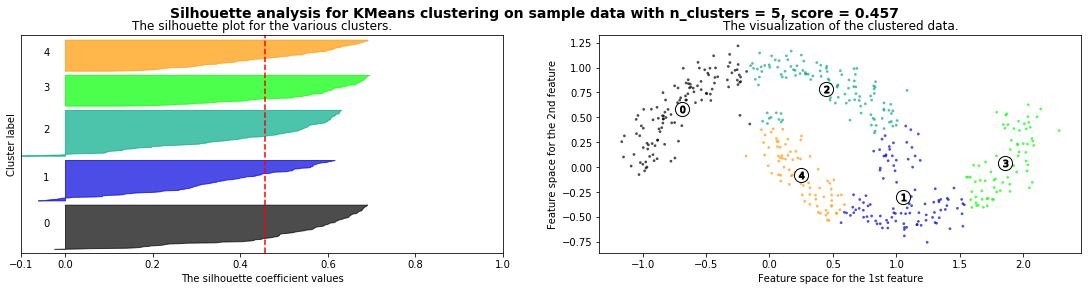

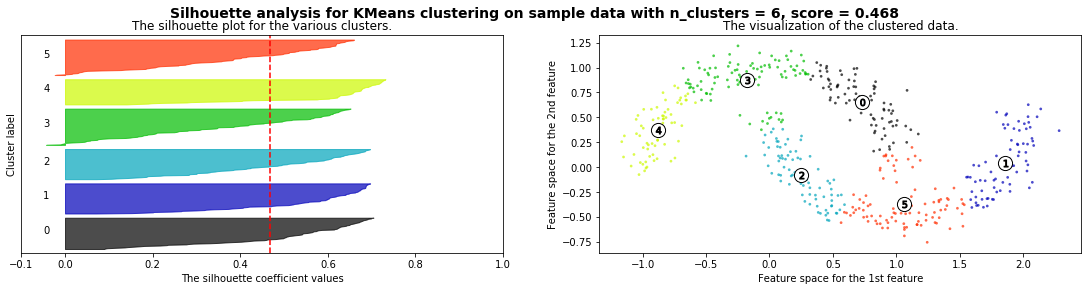

In [30]:
silhouette_analysis(X)

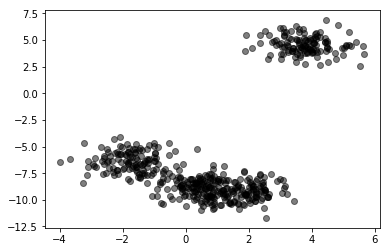

In [16]:
X,_ = make_blobs(500, cluster_std=.8, centers=4)
plt.scatter(X[:,0], X[:,1], alpha=.5, color="black")

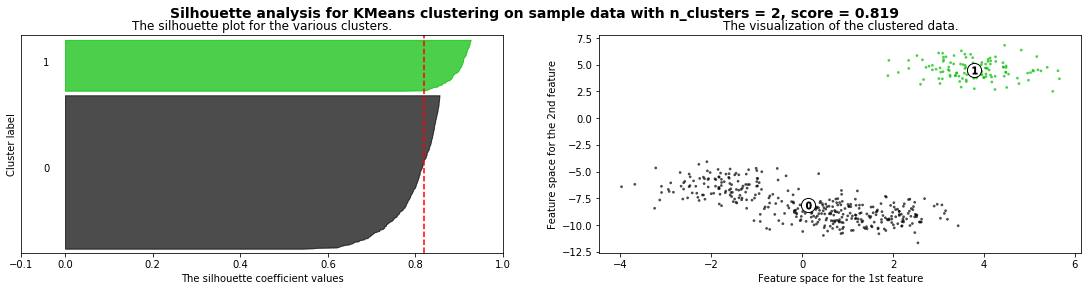

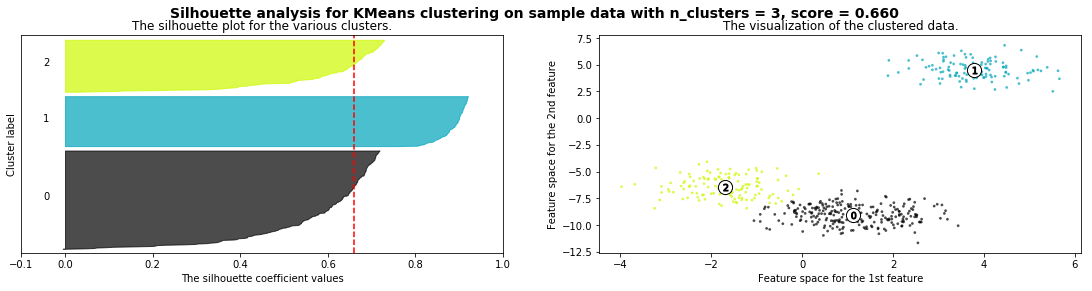

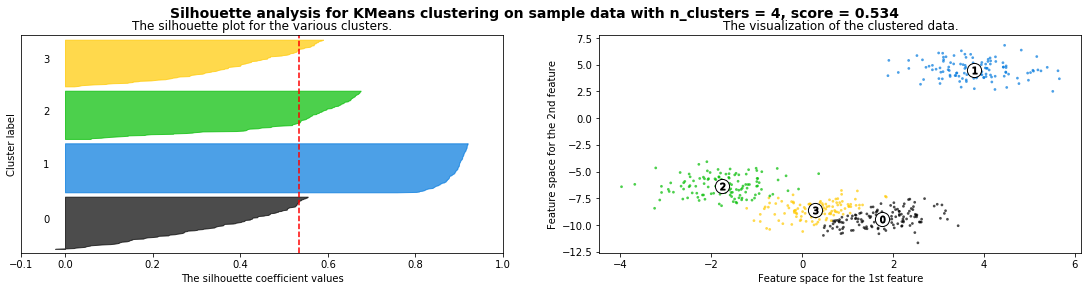

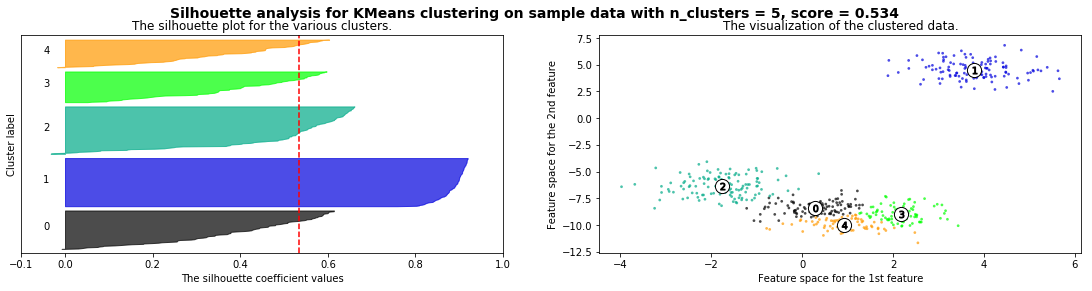

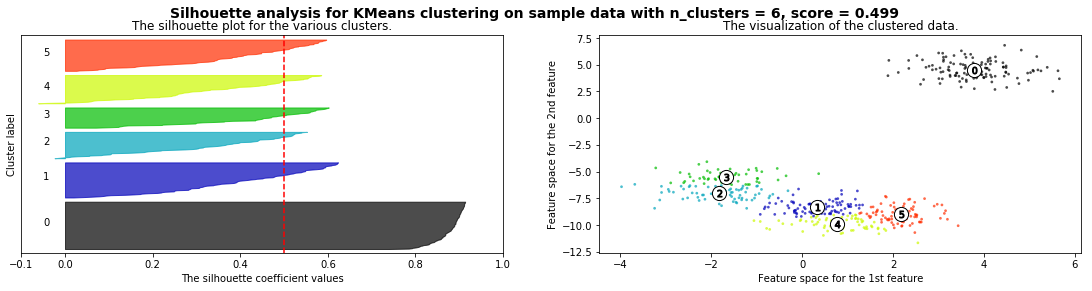

In [17]:
silhouette_analysis(X)

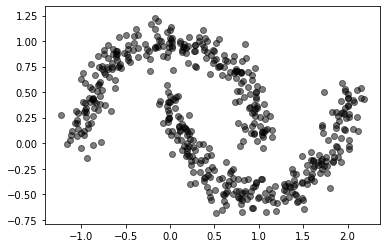

In [23]:
X,_ = make_moons(500, noise=.1)
plt.scatter(X[:,0], X[:,1], color="black", alpha=.5)

son **_naturales_** los clusters formados con los siguientes datos?

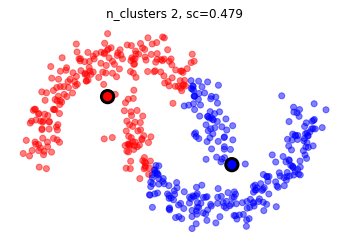

In [31]:
X,_ = make_moons(500, noise=.1)
mlutils.plot_cluster_predictions(KMeans(), X, n_clusters=2,cmap=plt.cm.bwr, show_metric=True)

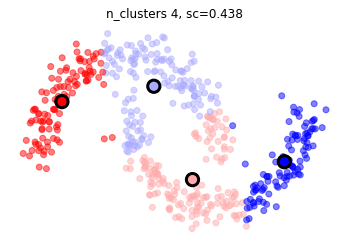

In [33]:
mlutils.plot_cluster_predictions(KMeans(), X, n_clusters=4,cmap=plt.cm.bwr, show_metric=True)

## Métodos basados en densidad - DBSCAN

es necesario especificar $\epsilon$ (radio máximo de una vecindad) y `min_samples`.

cómo se comporta la métrica de silueta? qué métrica usarías?

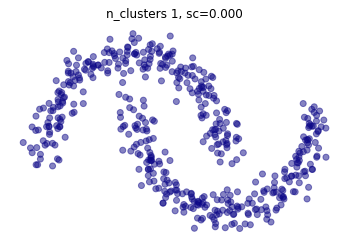

In [35]:
X,_ = make_moons(500, noise=.1)
dbs = DBSCAN(eps=.15, min_samples=4, metric='euclidean')
mlutils.plot_cluster_predictions(dbs, X, cmap=plt.cm.plasma, show_metric=True)

muy sensible a $\epsilon$. observa también que la métrica de silueta es muy sensible a los outliers.

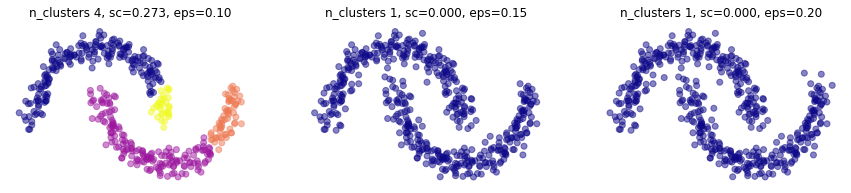

In [37]:
plt.figure(figsize=(15,3))
for i,eps in enumerate([.1,.15,.2]):
    plt.subplot(1,3,i+1)
    mlutils.plot_cluster_predictions(DBSCAN(eps=eps, min_samples=4, metric='euclidean'), X, 
                                     cmap=plt.cm.plasma, show_metric=True, title_str=", eps=%.2f"%eps)


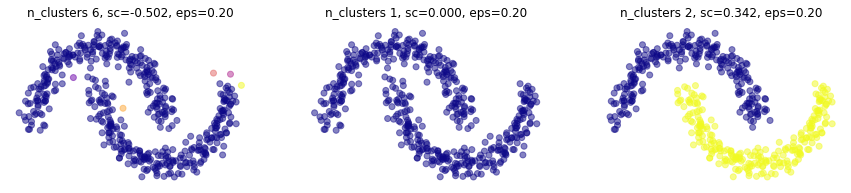

In [38]:
plt.figure(figsize=(15,3))
for i,min_samples in enumerate([1,4,10]):
    plt.subplot(1,3,i+1)
    mlutils.plot_cluster_predictions(DBSCAN(eps=.15, min_samples=min_samples, metric='euclidean'), X, 
                                     cmap=plt.cm.plasma, show_metric=True, title_str=", eps=%.2f"%eps)


## Métodos basados en conectividad - Agglomerative Clustering (Hierarchical)

consulta los parámetros en [sklearn doc](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) para describir una caracterización de la estructura subyacente.

observa cómo podemos construir una matrix de conectividad de k-vecinos alrededor de cualquier punto.

In [39]:
X,_ = make_moons(500, noise=.1)

(-0.7736222302611765, 1.344908685522608)

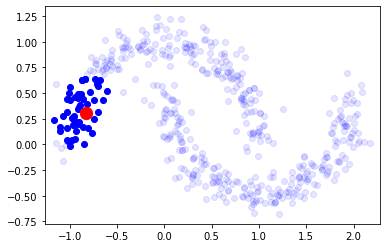

In [51]:
from sklearn.neighbors import kneighbors_graph
i = np.random.randint(len(X))
knn_graph = kneighbors_graph(X, 50, include_self=False)

nn = X[knn_graph[i].toarray()[0].astype(bool)]
plt.scatter(nn[:,0], nn[:,1], color="blue", alpha=1)
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.1)
plt.scatter(X[i,0], X[i,1], s=150, color="red")
plt.xlim(np.min(X[:,0])-.1, np.max(X[:,0])+.1)
plt.ylim(np.min(X[:,1])-.1, np.max(X[:,1])+.1)

In [52]:
knn_graph

<500x500 sparse matrix of type '<class 'numpy.float64'>'
	with 25000 stored elements in Compressed Sparse Row format>

usamos esta matriz de conectividad para suministrar informción de estructura al algoritmo

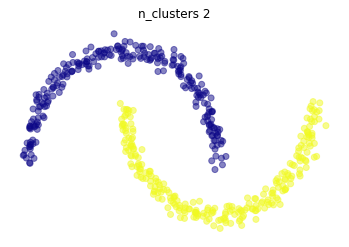

In [53]:
from sklearn.neighbors import kneighbors_graph
X,_ = make_moons(500, noise=.05)
knn_graph = kneighbors_graph(X, 20, include_self=False)
ac = AgglomerativeClustering(connectivity=knn_graph, linkage="average")

mlutils.plot_cluster_predictions(ac, X, n_clusters=2, cmap=plt.cm.plasma)

In [27]:
k = knn_graph.todense()
print (k.shape)
k

(500, 500)


matrix([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

observa la respuesta a diferentes tamaños de vecindad.

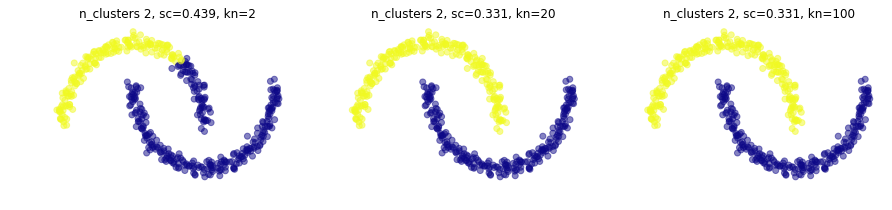

In [28]:
plt.figure(figsize=(15,3))
for i,kn in enumerate([2,20,100]):
    plt.subplot(1,3,i+1)
    knn_graph = kneighbors_graph(X, kn, include_self=False)
    mlutils.plot_cluster_predictions(AgglomerativeClustering(connectivity=knn_graph, linkage="average"), X, 
                                     n_clusters=2, 
                                     cmap=plt.cm.plasma, show_metric=True, title_str=", kn=%d"%kn)

y a distintos niveles de ruido en el dataset

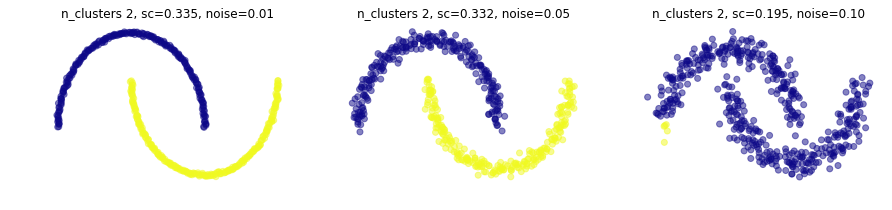

In [29]:
plt.figure(figsize=(15,3))
for i,noise in enumerate([.01,.05,.1]):
    plt.subplot(1,3,i+1)
    X,_ = make_moons(500, noise=noise)
    knn_graph = kneighbors_graph(X, 20, include_self=False)
    mlutils.plot_cluster_predictions(AgglomerativeClustering(connectivity=knn_graph, linkage="average"), X, 
                                     n_clusters=2, 
                                     cmap=plt.cm.plasma, show_metric=True, title_str=", noise=%.2f"%noise)

## Experimenta

observa los resultados de clustering con distintos algoritmos y datasets sintéticos.


- Consulta [dataset generation](http://scikit-learn.org/stable/modules/classes.html#samples-generator) en sklearn.
- Consulta [comparing clustering](http://scikit-learn.org/0.18/auto_examples/cluster/plot_cluster_comparison.html) para datasets sintéticos.

observa en especial si **silhouette** corresponde a tu intuición.

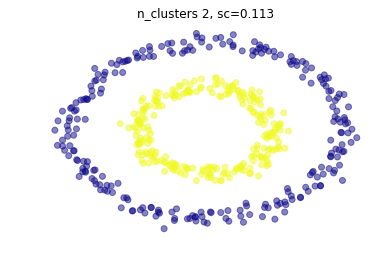

In [30]:
from sklearn import datasets
X,_ = datasets.make_circles(500, noise=.05, factor=.5)
knn_graph = kneighbors_graph(X, 10, include_self=False)
ac = AgglomerativeClustering(connectivity=knn_graph, linkage="average")
mlutils.plot_cluster_predictions(ac, X, n_clusters=2, cmap=plt.cm.plasma, show_metric=True)

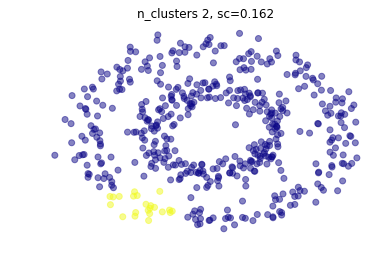

In [31]:
from sklearn import datasets
X,_ = datasets.make_circles(500, noise=.1, factor=.5)
knn_graph = kneighbors_graph(X, 50, include_self=False)
ac = AgglomerativeClustering(connectivity=knn_graph, linkage="average")
mlutils.plot_cluster_predictions(ac, X, n_clusters=2, cmap=plt.cm.plasma, show_metric=True)

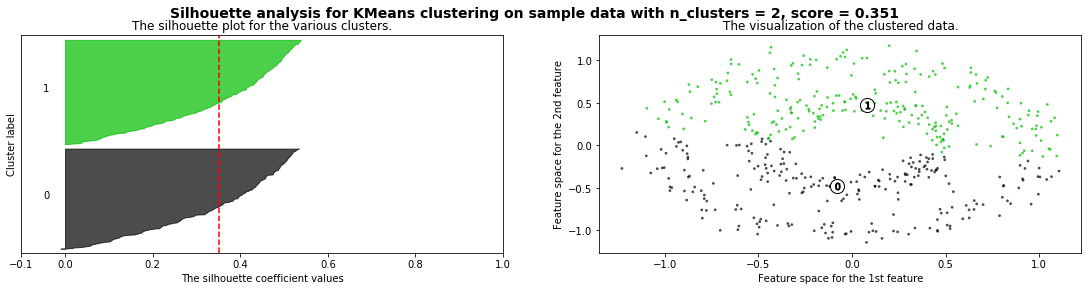

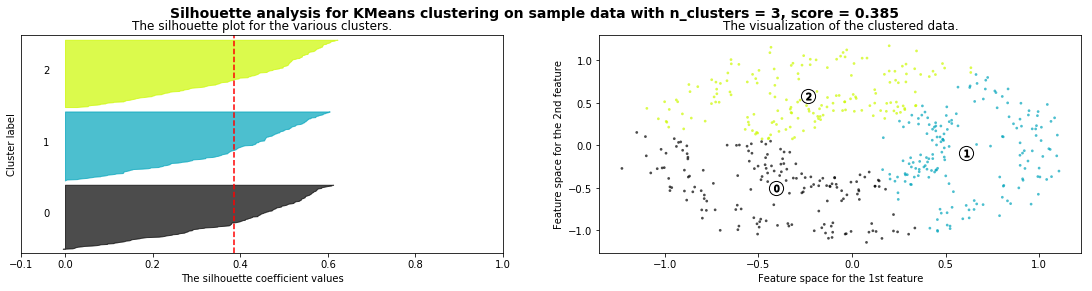

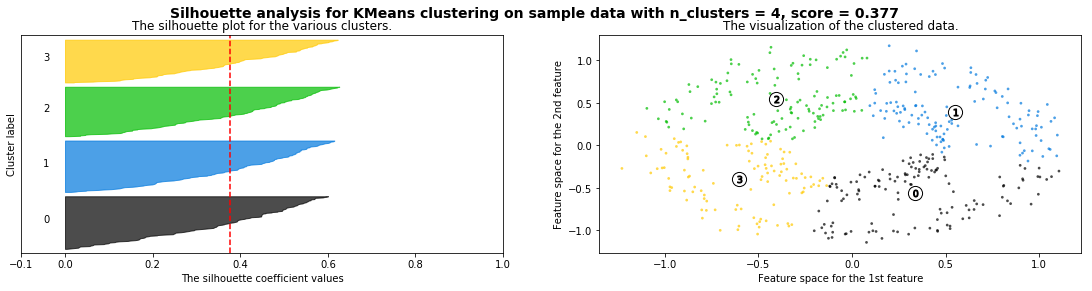

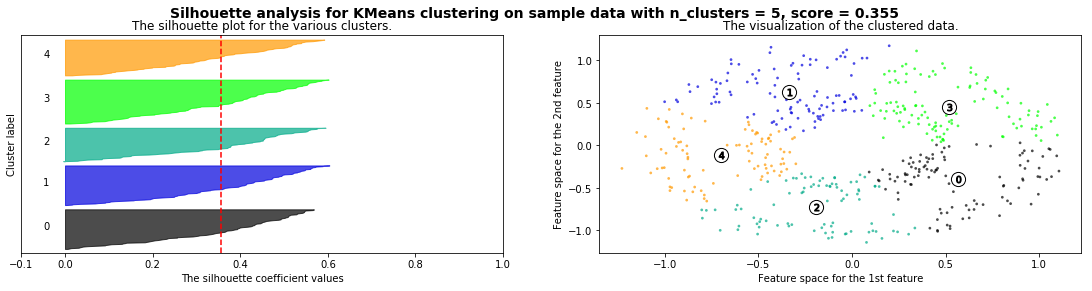

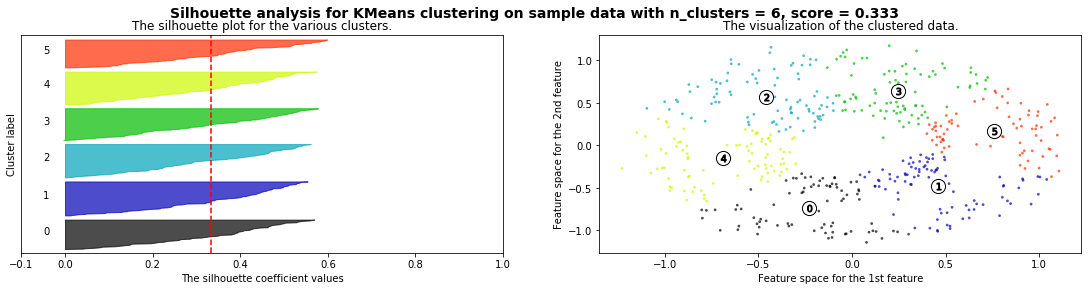

In [32]:
silhouette_analysis(X)